In [1]:
import yfinance as yf
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = yf.download(
    "GOOGL DFS DIS PDD OXY MTCH ASR TGT ZROZ C",
    start = '2022-01-01',
    end = '2023-12-31'
)

data.index = data.index.to_series().apply(lambda x: x.date())
data = data['Adj Close']

[*********************100%%**********************]  10 of 10 completed


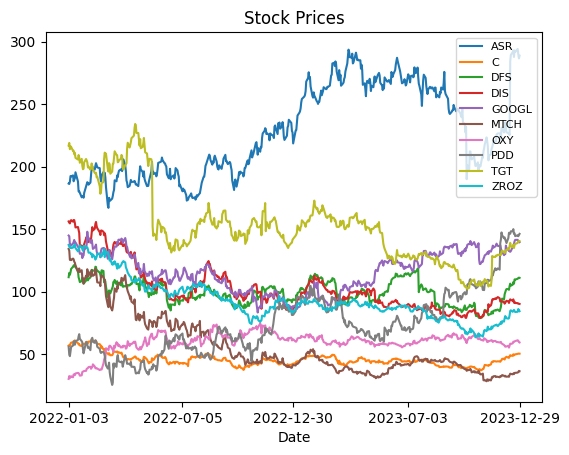

In [2]:
data.plot()
plt.legend(fontsize=8)
plt.title('Stock Prices')
plt.xticks(data.index[::125])
plt.show()

### a) Compute Daily Log Returns

In [3]:
# Take the ratio of the previous day's price
log_return = data / data.shift(1)
# Drop NA so log can be taken
log_return.dropna(inplace=True)

log_return = np.log(log_return)

log_return

Ticker,ASR,C,DFS,DIS,GOOGL,MTCH,OXY,PDD,TGT,ZROZ
Date,,,,,,,,,,
2022-01-04,-0.001654,0.007735,0.030383,-0.006592,-0.004091,-0.009431,0.072036,-0.118719,0.009526,-0.009352
2022-01-05,0.009690,-0.011705,-0.013666,-0.003474,-0.046962,-0.057658,-0.048176,-0.026234,-0.022937,-0.006813
2022-01-06,0.023634,0.032251,0.017909,0.010958,-0.000200,0.004293,0.029428,0.071558,0.010821,0.006127
2022-01-07,-0.001555,0.013314,0.023099,0.005910,-0.005317,-0.006287,0.013643,0.069824,-0.002467,-0.008686
2022-01-10,0.004424,0.003793,0.014455,-0.007824,0.011988,0.010245,-0.025310,0.019311,-0.014666,0.002904
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.004464,0.005125,-0.001530,-0.010927,0.007591,0.001706,0.006103,-0.015385,0.005938,-0.007117
2023-12-26,0.008442,0.009393,0.005929,-0.000769,0.000212,0.005101,0.010307,0.005109,0.005903,0.002105
2023-12-27,-0.014922,0.002335,0.005270,-0.006287,-0.008159,0.012081,-0.006532,-0.005316,0.009527,0.025835


### b) Estimate Annualized Log-Return

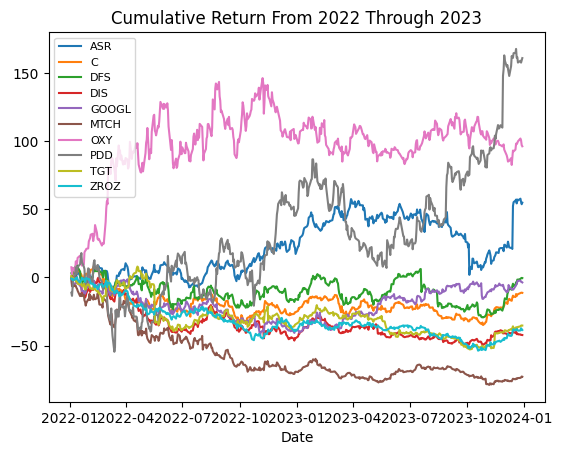

In [4]:
cumulative_return = (np.exp(log_return.cumsum()) - 1) * 100
cumulative_return.plot()
plt.title('Cumulative Return From 2022 Through 2023')
plt.legend(fontsize=8)
plt.show()

### Estimate Annualized Variance-Covariance Log-Return

#######Robust Mu
                
Ticker          
ASR     0.310615
C      -0.066615
DFS     0.307530
DIS    -0.076099
GOOGL   0.044562
MTCH   -0.326342
OXY     0.334100
PDD     0.375995
TGT    -0.085899
ZROZ   -0.166761

#######Robust Variance-Covariance Matrix
Ticker       ASR         C       DFS       DIS     GOOGL      MTCH       OXY  \
Ticker                                                                         
ASR     0.077021  0.026646  0.024509  0.027668  0.025997  0.040791  0.012839   
C       0.026646  0.062194  0.052827  0.040814  0.034264  0.057723  0.036279   
DFS     0.024509  0.052827  0.080889  0.047016  0.038293  0.069263  0.033479   
DIS     0.027668  0.040814  0.047016  0.072065  0.046152  0.069969  0.026965   
GOOGL   0.025997  0.034264  0.038293  0.046152  0.094871  0.080526  0.021351   
MTCH    0.040791  0.057723  0.069263  0.069969  0.080526  0.215046  0.027845   
OXY     0.012839  0.036279  0.033479  0.026965  0.021351  0.027845  0.123514   
PDD     0.045325 

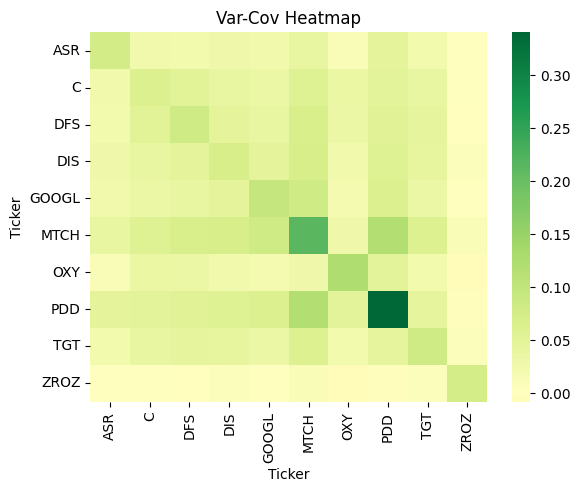

In [5]:
from sklearn.covariance import MinCovDet
import seaborn as sns

mcd = MinCovDet()

mcd.fit(log_return)

robust_vcov = pd.DataFrame(mcd.covariance_, columns=data.columns, index = data.columns)
annual_robust_vcov = robust_vcov * 252

robust_mu = pd.DataFrame(mcd.location_, index=data.columns, columns = [''])
annual_robust_mu = robust_mu * 252


print('#######Robust Mu')
print(annual_robust_mu)
print('')

print("#######Robust Variance-Covariance Matrix")
print(annual_robust_vcov)

sns.heatmap(annual_robust_vcov, cmap='RdYlGn', center=0)
plt.title('Var-Cov Heatmap')
plt.show()

### c) Plot the Minimum Variance Curve

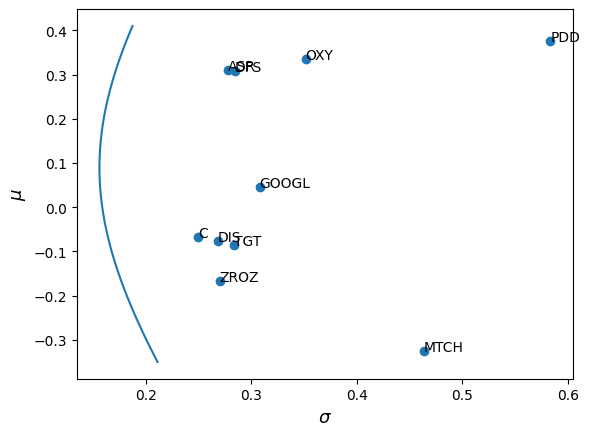

In [25]:
# Minimum Variance Portfolio
ones = np.ones(10)
iC = np.linalg.inv(annual_robust_vcov)
w_star = (np.dot(ones.T , np.dot(iC, ones)))**-1 * np.dot(iC, ones)
mu_star = 0


# Minimum Variance Curve
def min_variance_curve(mu, means, vcov):
    "Takes a mu (y) value and returns the corresponding minimum variance (x)"
    iC = np.linalg.inv(vcov)
    meanstil = np.hstack((ones.reshape((-1,1)), means.values))
    mutil = np.array([1., mu]).reshape((-1,1))
    x = np.sqrt(
        mutil.T @ np.linalg.inv(meanstil.T @ iC @ meanstil) @ mutil
    )
    return x[0][0]

mus = np.linspace(-.35, .41, 100)

x = [min_variance_curve(mu, annual_robust_mu, annual_robust_vcov) for mu in mus]

plt.plot(x, mus)

plt.scatter(np.sqrt(np.diag(annual_robust_vcov)), annual_robust_mu)
plt.xlabel('$\sigma$', fontsize=13)
plt.ylabel('$\mu$', fontsize=13)
for i in range(10):
    plt.text(np.sqrt(np.diag(annual_robust_vcov))[i], annual_robust_mu.values[i], data.columns[i])
plt.show()

In [7]:
# def portfolio_performance(returns, vcov, weights):
#     retrn = np.dot(weights.T, returns)
#     vcov = np.dot(weights.T, np.dot(vcov, weights))

#     return retrn, vcov

# n = 500
# portfolio_returns = np.zeros(n)
# portfolio_var = np.zeros(n)

# for i in range(n):
#     randn = np.random.randn(10)
#     weights = np.reshape(randn / np.sum(randn), (-1,1))

#     portfolio_returns[i], portfolio_var[i] = portfolio_performance(robust_mu, robust_cov, weights)

# plt.scatter(portfolio_returns, portfolio_var)
# plt.show()

NameError: name 'robust_cov' is not defined

Questions:
- VCov stuff
- Annualize for plot?
- Why my mu values are very different relative to each other than Cosmin's


Notes:
- Cov:
    - Don't use Cov
    - Should be quarterly rebalancing
    - Ask Ichiba
- Mean (robust cov/var estimate)
    - Ignores large moves
    - Gives better estimate
- Capital market line
    - Intersection of with efficient frontier
        - Max sharpe portfolio (market portfolio)
        